# Training on the spectrogram of the signal

Computing the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of a
signal is a common visualization method in signal processing to treat
signals as 2D images. Recent works have looked at using the spectrogram
for classification, thus converting the signal recognition task into an image
recognition one and leveraging techniques from computer vision.

## Setup

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from tqdm.auto import tqdm
from sklearn import metrics
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))


Using cuda device: 0


## Load dataset 

In [2]:

DATASET_PATH = 'dataset/'  # path to your extracted windows

with open(DATASET_PATH+'info.json', 'r') as f:
    info = json.load(f)

X = np.memmap(DATASET_PATH+'X.dat', mode='r', dtype=info['X_dtype'], shape=tuple(info['X_shape']))
Y = np.memmap(DATASET_PATH+'Y.dat', mode='r', dtype=info['Y_dtype'], shape=tuple(info['Y_shape']))
T = np.memmap(DATASET_PATH+'T.dat', mode='r', dtype=info['T_dtype'], shape=tuple(info['T_shape']))
P = np.memmap(DATASET_PATH+'P.dat', mode='r', dtype=info['P_dtype'], shape=tuple(info['P_shape']))

labels = np.unique(Y)
num_labels = len(labels)

Y = np.where(Y.reshape(-1,1)==labels)[1]  # to numeric

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('T shape:', T.shape)
print('P shape:', P.shape)


X shape: (294309, 3000, 3)
Y shape: (294309,)
T shape: (294309,)
P shape: (294309,)


## Train/test split

In [3]:

# Take out 10 participants
test_ids = ['002', '003', '004', '005', '006', 
            '007', '008', '009', '010', '011']
mask_test = np.isin(P, test_ids)
mask_train = ~mask_test
X_train, Y_train, P_train, T_train = \
    utils.ArrayFromMask(X, mask_train), Y[mask_train], P[mask_train], T[mask_train]
X_test, Y_test, P_test, T_test = \
    utils.ArrayFromMask(X, mask_test), Y[mask_test], P[mask_test], T[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)



Shape of X_train: (274462, 3000, 3)
Shape of X_test: (19847, 3000, 3)


 ## Visualization

Let's visualize the spectrograms of the acceleration norm for each activity class.
We use
[scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html).
Here, the arguments `nperseg` and `noverlap` determine the size of the
resulting spectrogram. For `nperseg=120` and `noverlap=72`, the spectrogram
size is $61\times 61$.


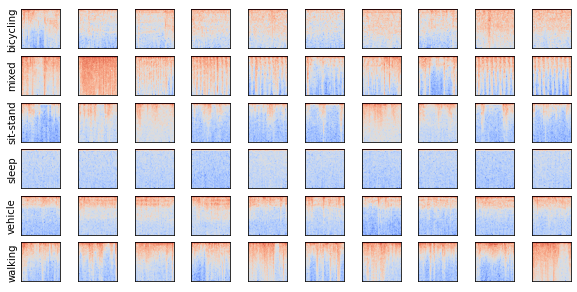

In [4]:
# Spectrogram parameters
N_FFT = 120
HOP_LENGTH = 48
WINDOW = 'hann'

NUM_PLOTS = 10
fig, axs = plt.subplots(num_labels, NUM_PLOTS, figsize=(10,5))
for i in range(num_labels):
    axs[i,0].set_ylabel(labels[i])
    idxs = np.where(Y==i)[0]
    for j in range(NUM_PLOTS):
        _, _, z = scipy.signal.stft(
            np.linalg.norm(X[idxs[j]], axis=1),  # acceleration vector norm
            nperseg=N_FFT,
            noverlap=N_FFT-HOP_LENGTH,
            window=WINDOW,
            boundary=None, padded=False
        )
        z = np.log(np.abs(z) + 1e-16)
        axs[i,j].imshow(z, cmap='coolwarm')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.show()


## Architecture design

As a baseline, let's use a convolutional neural network (CNN) with a typical
pyramid-like structure. The input to the network is a `(N,3,61,61)` array,
corresponding to `N` spectrograms for each axis signal. Again, note the
*channels-first* format: `(3,61,61)` instead of `(61,61,3)`.

The output of the CNN is a `(N,num_labels)` array where each row contains
predicted unnormalized class scores or *logits*; pass each row to a softmax
if you want to convert it to probabilities.


In [5]:
class ConvBNReLU(nn.Module):
    ''' Convolution + batch normalization + ReLU is a common trio '''
    def __init__(
        self, in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.main(x)

class CNN(nn.Module):
    ''' Typical CNN design with pyramid-like structure '''
    def __init__(self, output_size=5, in_channels=3, num_filters_init=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init,
            3, 2, 1, bias=False),  # 61x61 -> 31x31
            ConvBNReLU(num_filters_init, num_filters_init*2,
            3, 2, 1, bias=False),  # 31x31 -> 16x16
            ConvBNReLU(num_filters_init*2, num_filters_init*4,
            4, 2, 1, bias=False),  # 16x16 -> 8x8
            ConvBNReLU(num_filters_init*4, num_filters_init*8,
            4, 2, 1, bias=False),  # 8x8 -> 4x4
            ConvBNReLU(num_filters_init*8, num_filters_init*16,
            4, 1, 0, bias=False),  # 4x4 -> 1x1
            nn.Conv2d(num_filters_init*16, output_size,
            1, 1, 0, bias=True)
        )

    def forward(self, x):
        return self.cnn(x).view(x.shape[0],-1)


## Helper functions


In [6]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    ''' Create a (batch) iterator over the dataset. 
    Alternatively, use PyTorch's Dataset and DataLoader classes.
    See https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''

    # Spectrogram parameters
    N_FFT = 120
    HOP_LENGTH = 48
    WINDOW = torch.hann_window(N_FFT)

    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')  # PyTorch defaults to float32
        X_batch = np.transpose(X_batch, (0,2,1))  # channels first: (N,M,3) -> (N,3,M)
        X_batch = torch.from_numpy(X_batch)
        Z_batch = torch.stft(
            # Pack channel and batch dimensions. Also upload the batch to GPU
            # (if available) to compute the STFT.
            # Let the GPU do the work -- Gordon Ramsey
            X_batch.reshape(-1, X_batch.shape[-1]).to(device),
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            window=WINDOW.to(device),
            center=False,
            return_complex=False
        )
        # Unpack channel and batch dimensions
        Z_batch = Z_batch.view(*X_batch.shape[:2], *Z_batch.shape[1:])
        Z_batch = torch.log(torch.norm(Z_batch, dim=-1) + 1e-16)
        if y is None:
            yield Z_batch
        else:
            y_batch = torch.from_numpy(y[idxs_batch])
            y_batch = y_batch.to(device)  # upload to GPU for consistency
            yield Z_batch, y_batch


def forward_by_batches(cnn, X):
    ''' Forward pass model on a dataset. 
    Do this by batches so that we don't blow up the memory. '''
    Y = []
    cnn.eval()
    with torch.no_grad():
        for z in create_dataloader(X, batch_size=1024, shuffle=False):  # do not shuffle here!
            z = z.to(device)
            Y.append(cnn(z))
    cnn.train()
    Y = torch.cat(Y)
    return Y


def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)  # scores
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y).to(device)).item()

    Y_pred = F.softmax(Y_pred, dim=1)  # convert to probabilities
    Y_pred = torch.argmax(Y_pred, dim=1)  # convert to classes
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    kappa = metrics.cohen_kappa_score(Y, Y_pred)

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}


## Hyperparameters, model instantiation, loss function and optimizer


In [7]:
num_filters_init = 32  # initial num of filters -- see class definition
in_channels = 3  # num channels of the signal -- equal to 3 for our raw triaxial timeseries
output_size = num_labels  # number of classes (sleep, sedentary, etc...)
num_epoch = 5  # num of epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)


CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

## Training


In [8]:
kappa_history = []
loss_history = []
loss_history_train = []
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(X_train, Y_train, batch_size, shuffle=True)
    losses = []
    for z, target in dataloader:
        z, target = z.to(device), target.to(device)
        cnn.zero_grad()
        output = cnn(z)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- track train loss
        losses.append(loss.item())

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch 
    # --------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(cnn, X_test, Y_test)
    loss_history.append(results['loss'])
    kappa_history.append(results['kappa'])


 ## Model performane 


Classifier performance
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.93      0.90      0.91       347
       mixed       0.52      0.61      0.56      1955
   sit-stand       0.90      0.87      0.88      8523
       sleep       0.94      0.95      0.94      7500
     vehicle       0.88      0.87      0.87       609
     walking       0.40      0.32      0.36       913

    accuracy                           0.85     19847
   macro avg       0.76      0.75      0.75     19847
weighted avg       0.85      0.85      0.85     19847



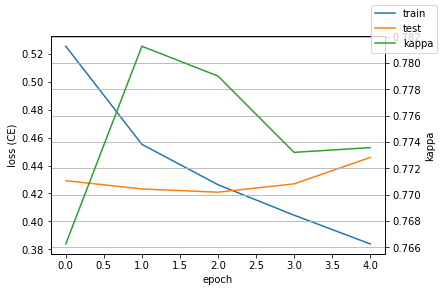

In [9]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train')
ax.plot(loss_history, color='C1', label='test')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
fig.show()

# Report
Y_test_pred_lab = labels[results['Y_pred']]  # to labels
Y_test_lab = labels[Y_test]  # to labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test_lab, Y_test_pred_lab)) 
